### Building a Neural Network and Training

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from torch import nn, optim
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
%config InlineBackend.figure_format='retina'
from pylab import rcParams
from matplotlib import rc
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/weatherAUS.csv')

In [5]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [6]:
df.shape

(145460, 23)

### Data Processing
We have many columns but only four of them will be necessary to predict whether it will rain today.

In [7]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

In [8]:
df

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No
...,...,...,...,...,...
145455,0.0,24.0,1024.6,No,No
145456,0.0,21.0,1023.5,No,No
145457,0.0,24.0,1021.0,No,No
145458,0.0,24.0,1019.4,No,No


In [9]:
df = df.dropna(how = 'any')

In [10]:
df

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No
...,...,...,...,...,...
145454,0.0,27.0,1024.7,No,No
145455,0.0,24.0,1024.6,No,No
145456,0.0,21.0,1023.5,No,No
145457,0.0,24.0,1021.0,No,No


In [11]:
df['RainToday'].replace({'No': 0, "Yes": 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

<ipython-input-11-b89930e59018>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RainToday'].replace({'No': 0, "Yes": 1}, inplace = True)
<ipython-input-11-b89930e59018>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)


In [12]:
df

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0,0
1,0.0,25.0,1010.6,0,0
2,0.0,30.0,1007.6,0,0
3,0.0,16.0,1017.6,0,0
4,1.0,33.0,1010.8,0,0
...,...,...,...,...,...
145454,0.0,27.0,1024.7,0,0
145455,0.0,24.0,1024.6,0,0
145456,0.0,21.0,1023.5,0,0
145457,0.0,24.0,1021.0,0,0


In [13]:
df.reset_index(inplace = True)

In [14]:
df.drop('index', inplace = True, axis = 1)

<ipython-input-14-7d4ad3ac7cce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('index', inplace = True, axis = 1)


In [15]:
df

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0,0
1,0.0,25.0,1010.6,0,0
2,0.0,30.0,1007.6,0,0
3,0.0,16.0,1017.6,0,0
4,1.0,33.0,1010.8,0,0
...,...,...,...,...,...
124684,0.0,27.0,1024.7,0,0
124685,0.0,24.0,1024.6,0,0
124686,0.0,21.0,1023.5,0,0
124687,0.0,24.0,1021.0,0,0


In [16]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

In [17]:
X

,Rainfall,Humidity3pm,RainToday,Pressure9am
0,0.6,22.0,0,1007.7
1,0.0,25.0,0,1010.6
2,0.0,30.0,0,1007.6
3,0.0,16.0,0,1017.6
4,1.0,33.0,0,1010.8
...,...,...,...,...
124684,0.0,27.0,0,1024.7
124685,0.0,24.0,0,1024.6
124686,0.0,21.0,0,1023.5
124687,0.0,24.0,0,1021.0


In [18]:
y

,RainTomorrow
0,0
1,0
2,0
3,0
4,0
...,...
124684,0
124685,0
124686,0
124687,0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

### Convert all the values into Tensors

In [20]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

In [21]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


In [22]:
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net = Net(X_train.shape[1])

(-1.5, 1.5)

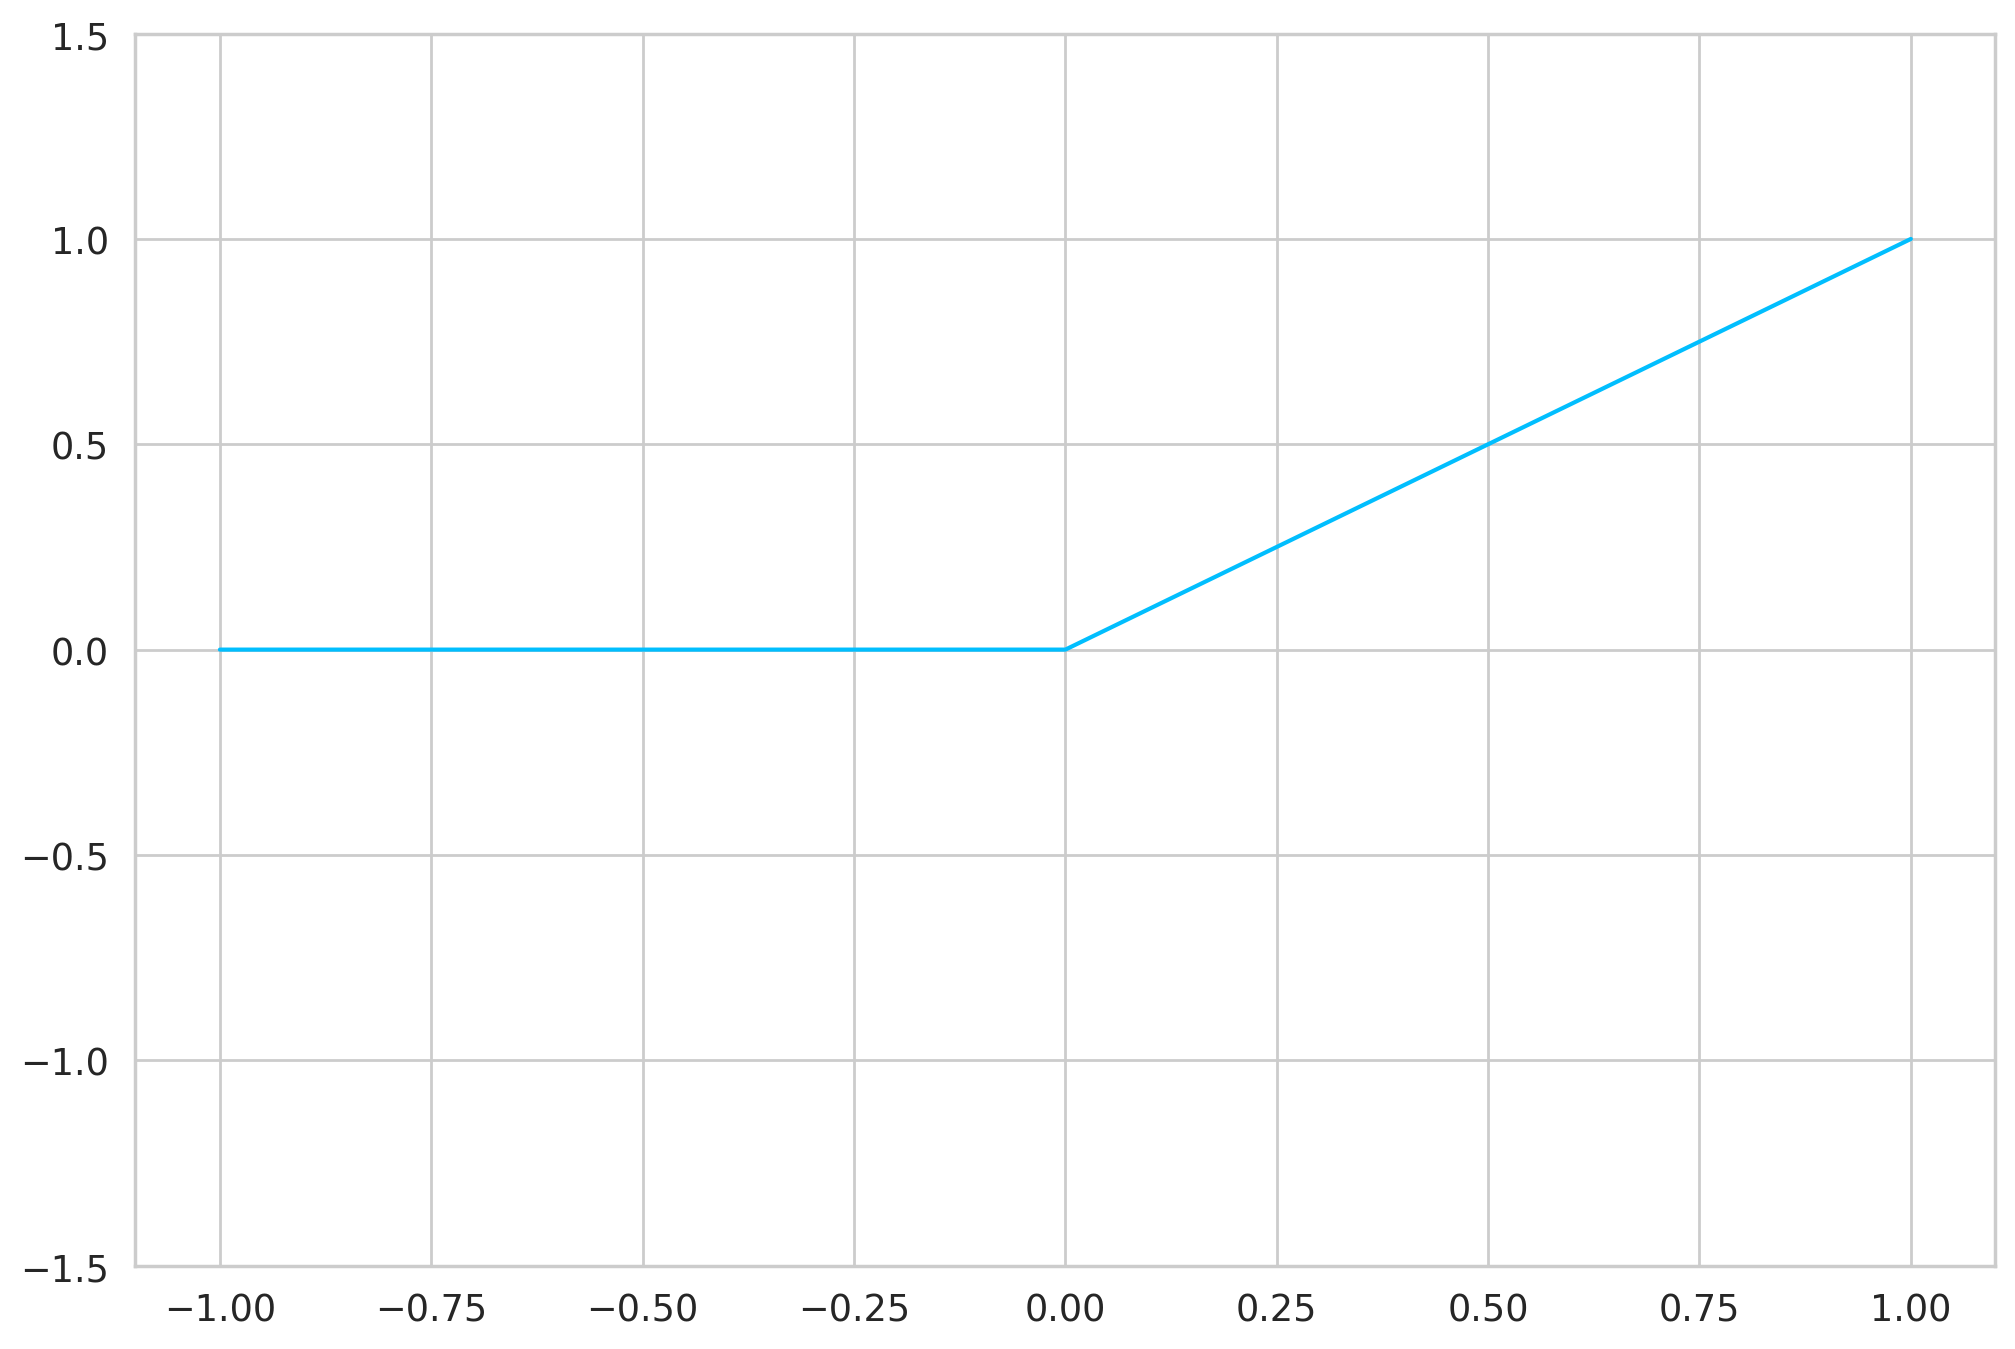

In [23]:
ax = plt.gca()

plt.plot(
    np.linspace(-1, 1, 5),
    F.relu(torch.linspace(-1, 1, steps=5)).numpy()
)

ax.set_ylim([-1.5, 1.5])

In [24]:
criterion = nn.BCELoss()

In [25]:
optimizer= optim.Adam(net.parameters(), lr = 0.001)

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [27]:
device

device(type='cpu')

In [28]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [29]:
net = net.to(device)

In [30]:
criterion = criterion.to(device)

In [31]:
## Finding Good Parameters
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [32]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

In [33]:
for epoch in range(1000):
  y_pred = net(X_train)
  y_pred = torch.squeeze(y_pred)
  train_loss = criterion(y_pred, y_train)

  if epoch % 100 == 0:
    train_acc = calculate_accuracy(y_train, y_pred)

    y_test_pred = net(X_test)
    y_test_pred = torch.squeeze(y_test_pred)

    test_loss = criterion(y_test_pred, y_test)

    test_accuracy = calculate_accuracy(y_test_pred, y_test)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

In [34]:
MODEL_PATH = '/content/model.pth'

In [35]:
torch.save(net, MODEL_PATH)

In [36]:
net = torch.load(MODEL_PATH)

In [37]:
## Evaluation
classes = ['No rain', 'Raining']

y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.81      0.96      0.88     19413
     Raining       0.62      0.22      0.33      5525

    accuracy                           0.80     24938
   macro avg       0.71      0.59      0.60     24938
weighted avg       0.77      0.80      0.76     24938



Text(0.5, 51.249999999999986, 'Predicted label')

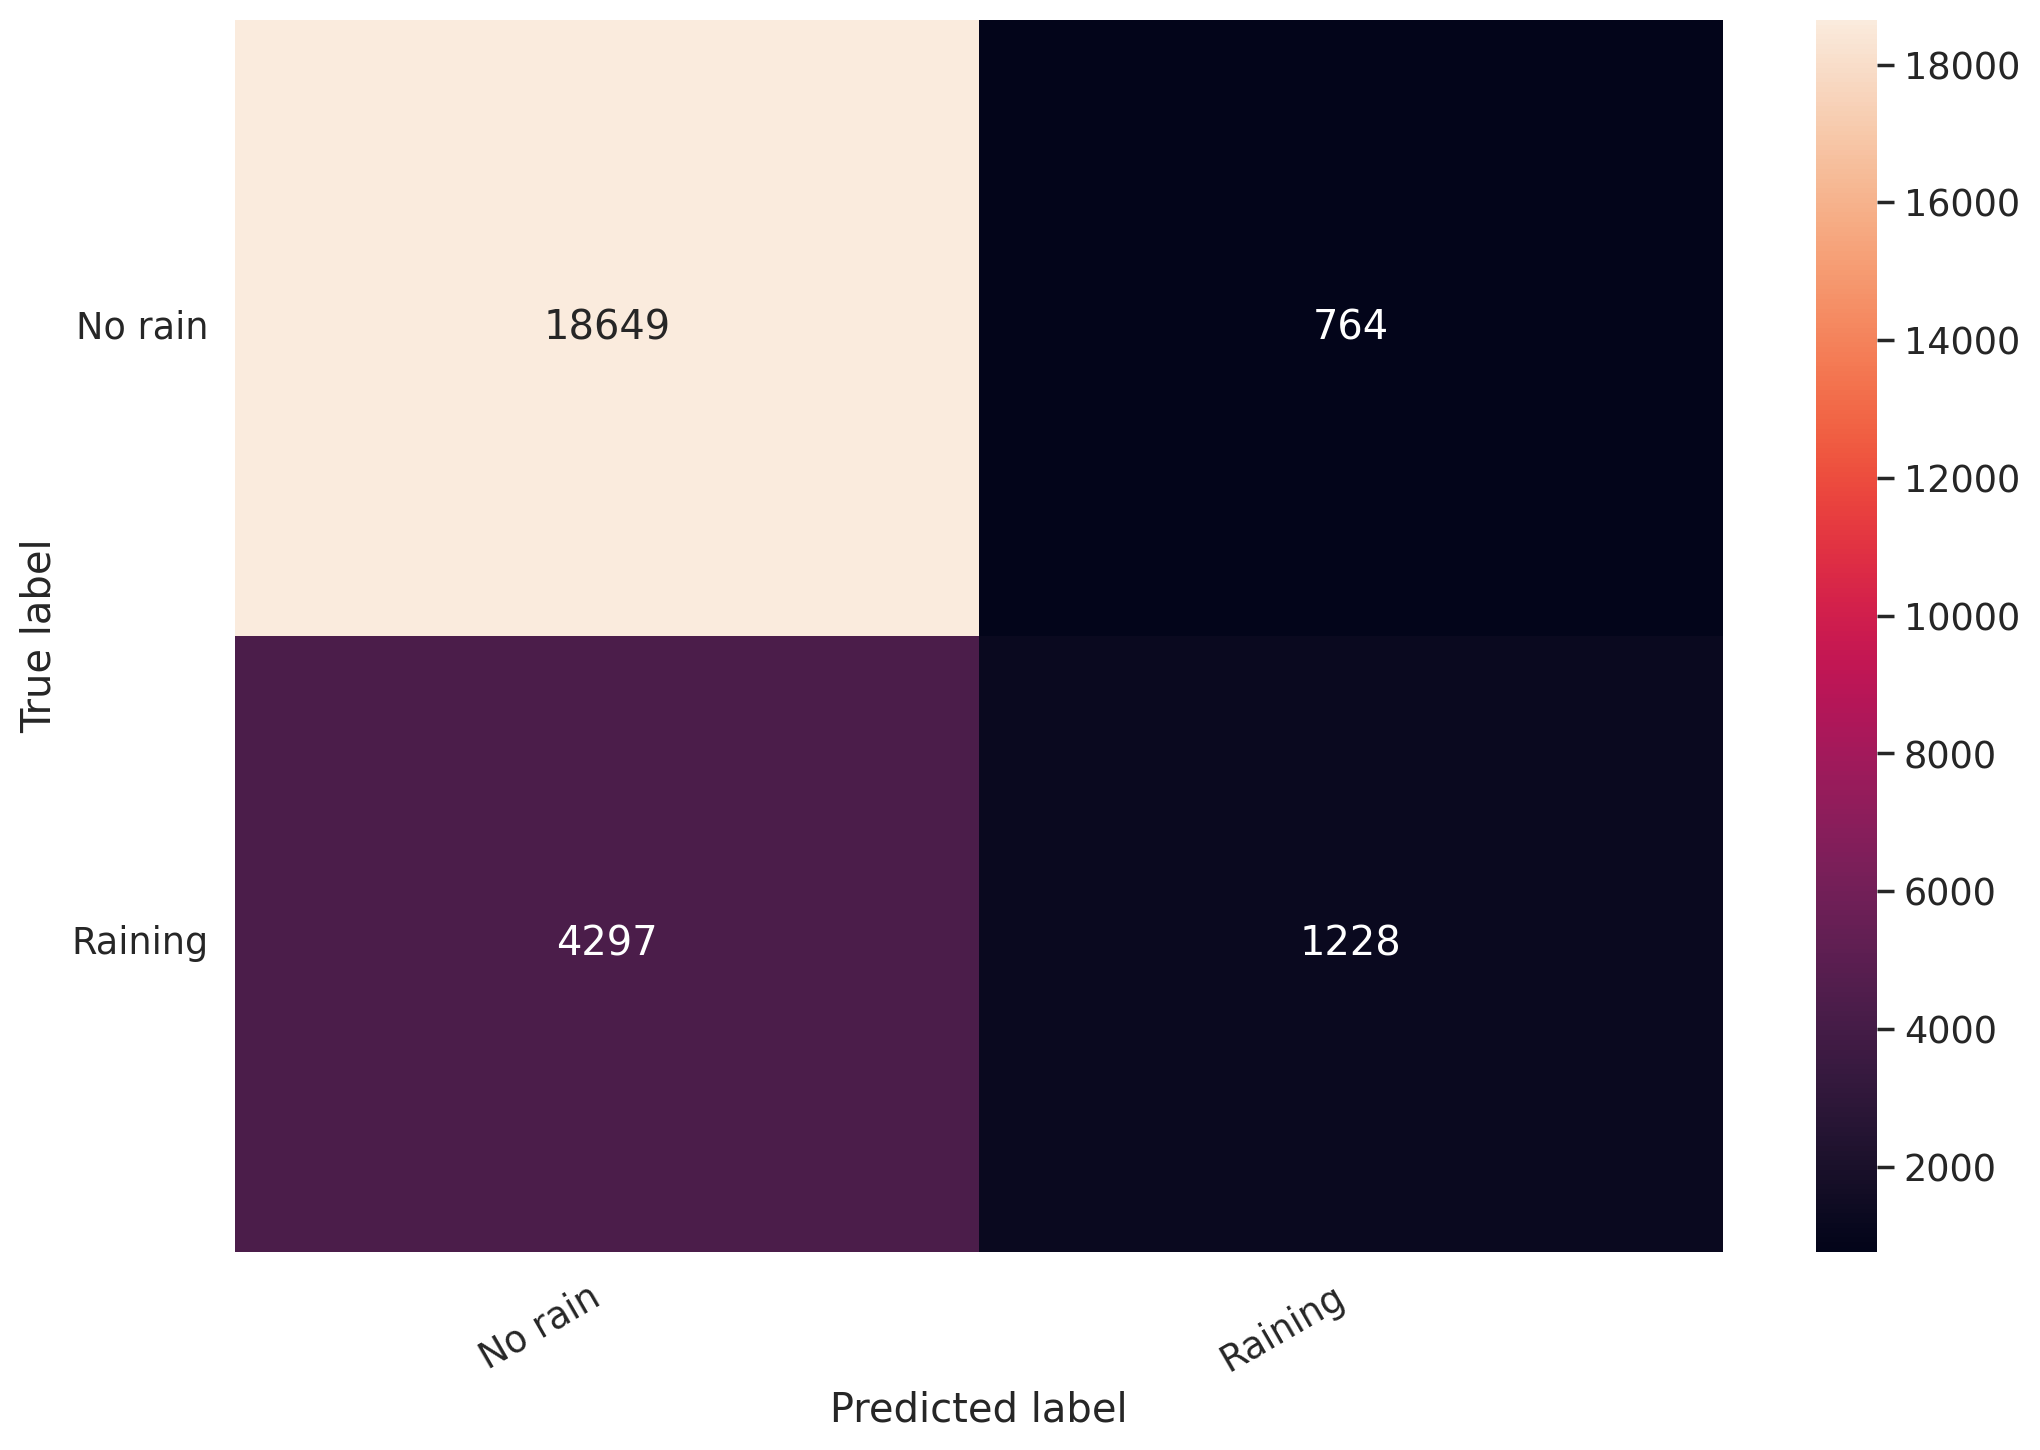

In [38]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = classes, columns =classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')